In [1]:
# import modules
import math
import numpy as np
import matplotlib.pyplot as plt


## 1. Noise-free data

First, we implement the function `simulate_sir_simple(lam, mu, I_0, T)` function.

In [2]:
# define a function that takes the parameters and simulates the epidemy using the Euler forward scheme to day T
def simulate_sir_simple(lam, mu, I_0, T, visualize = False):
  """
  input:
    lam: the infection rate
    mu: the recovery rate
    I_0: the initial number of infected individuals
  output:
    X: the sequence of the number of additive susceptible individuals and the number of additive recovered individuals
  """
  # define the time step
  dt = 1
  # initialize the vectors for S, I and R
  I = []
  S = []
  R = []
  S_delta = []
  R_delta = []
  # set the initial conditions
  I.append(I_0)
  S.append(1-I_0)
  R.append(0)
  S_delta.append(0)
  R_delta.append(0)
  # simulate the epidemy
  for t in range(T):
    S.append(S[t] - dt*(lam*S[t] * I[t]))
    I.append(I[t] + dt*(lam*S[t] * I[t] - mu*I[t]))
    R.append(R[t] + dt*(mu*I[t]))
    if t > 0:
      S_delta.append(S[t-1] - S[t])
      R_delta.append(R[t] - R[t-1])
  if visualize:
    # return the results
    return [(S[n], I[n], R[n]) for n in range(T+1)]
  else:
    return [(S_delta[n], R_delta[n]) for n in range(T)]

Then we run the simulation and visualize the results.

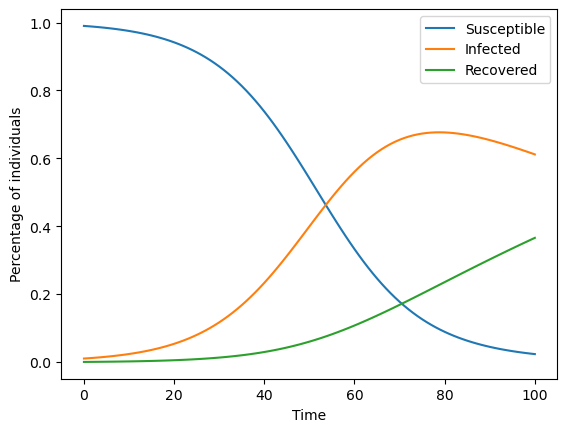

In [3]:
T = 100
# define the parameters
lam = 0.1
mu = 0.01
I_0 = 0.01

# simulate the epidemy
X = simulate_sir_simple(lam, mu, I_0, T, visualize=True)

# visualize the results
plt.figure()
plt.plot(X)
plt.xlabel('Time')
plt.ylabel('Percentage of individuals')
plt.legend(['Susceptible', 'Infected', 'Recovered'])

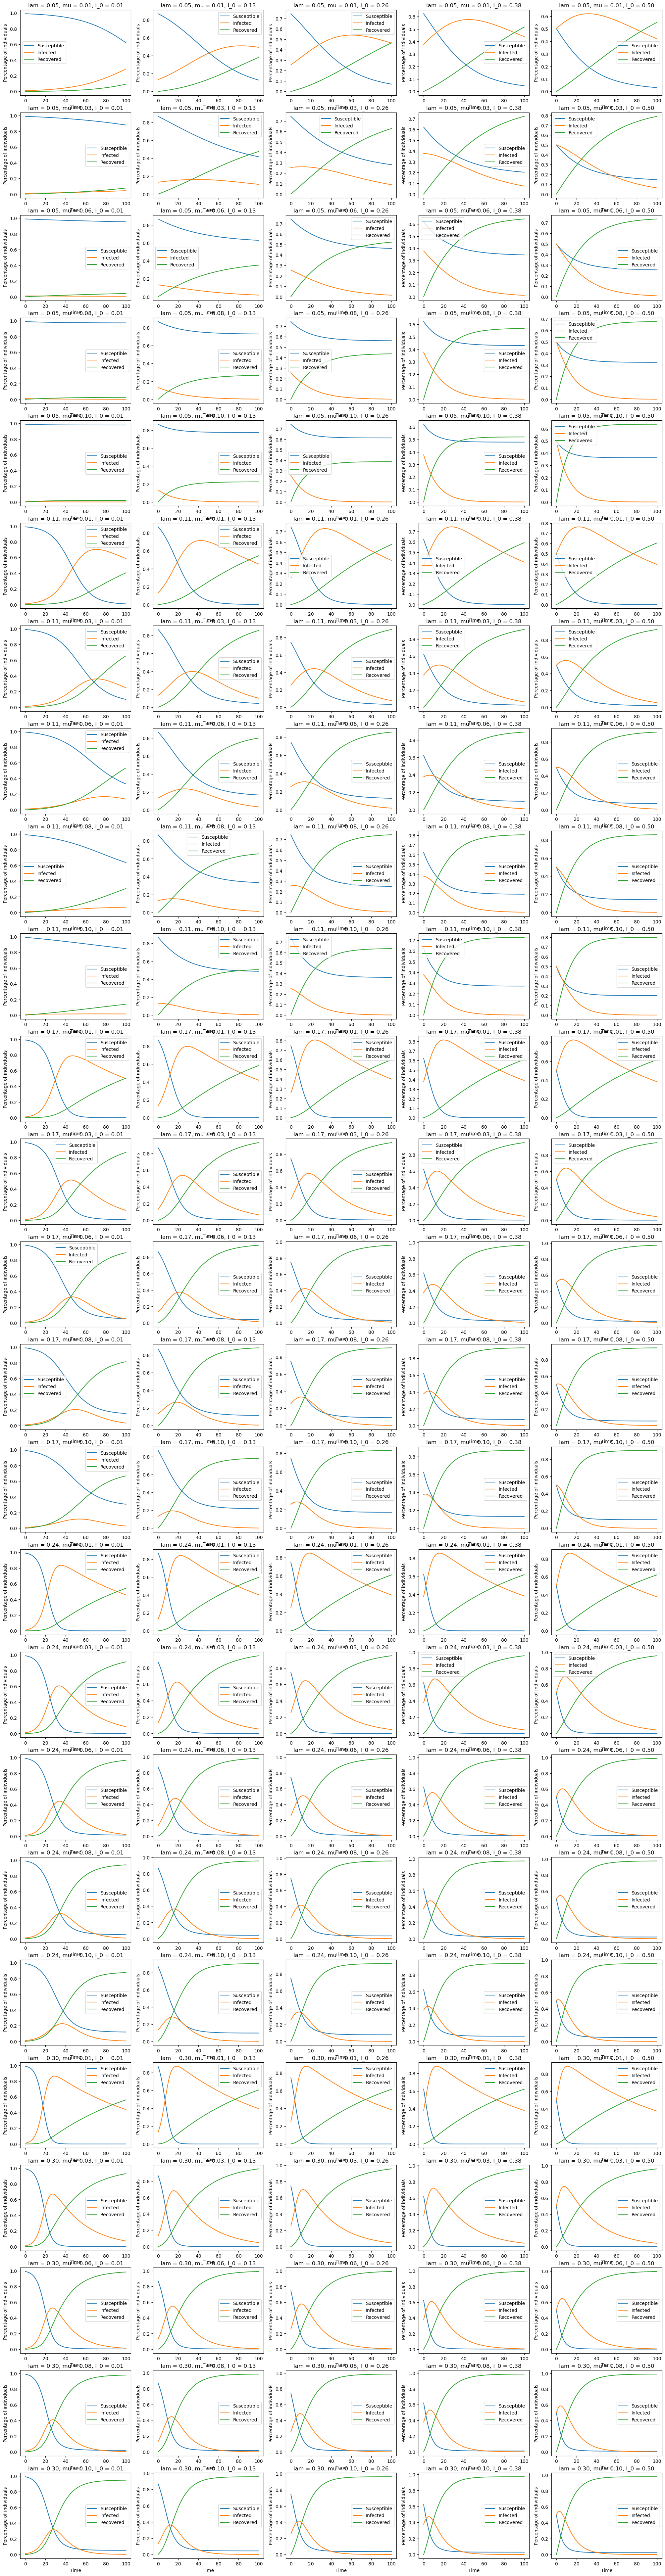

In [6]:
# Determine the suitable range of the parameters
num = 5
# define the parameters
lam = np.linspace(0.05, 0.3, num)
mu = np.linspace(0.01, 0.1, num)
I_0 = np.linspace(0.01, 0.5, num)

fig, axs = plt.subplots(num**2, num, figsize=(25, 20*num))
for i in range(len(lam)):
  for j in range(len(mu)):
    for k in range(len(I_0)):
      # simulate the epidemy
      X = simulate_sir_simple(lam[i], mu[j], I_0[k], T, visualize=True)
      # visualize the results in a 25*5 figure
      axs[i*num+j, k].plot(X)
      axs[i*num+j, k].set_xlabel('Time')
      axs[i*num+j, k].set_ylabel('Percentage of individuals')
      axs[i*num+j, k].legend(['Susceptible','Infected', 'Recovered'])
      axs[i*num+j, k].set_title('lam = {:.2f}, mu = {:.2f}, I_0 = {:.2f}'.format(lam[i], mu[j], I_0[k]))

plt.show()

In [4]:
# define simulation prior

import torch
import torch.nn as nn
import torch.optim as optim

def prior(lam_min, lam_max, mu_min, mu_max, I0_min, I0_max):
  """
  input:
    lam_min: the minimum value of the infection rate
    lam_max: the maximum value of the infection rate
    mu_min: the minimum value of the recovery rate
    mu_max: the maximum value of the recovery rate
    I0_min: the minimum value of the initial number of infected individuals
    I0_max: the maximum value of the initial number of infected individuals
  output:
    lam: the infection rate
    mu: the recovery rate
    I_0: the initial number of infected individuals
  """
  # sample the parameters
  lam = np.random.uniform(lam_min, lam_max)
  mu = np.random.uniform(mu_min, mu_max)
  I_0 = np.random.uniform(I0_min, I0_max)
  # return the results
  return lam, mu, I_0

In [7]:
# create the training data
sample_size = 1000
training_set = torch.randn(sample_size, 2, 10, 10)
training_labels = torch.randn(sample_size, 3)
# save X into training set
for i in range(sample_size):
  # sample the parameters
  lam, mu, I_0 = prior(0.05, 0.3, 0.01, 0.1, 0.01, 0.5)
  # simulate the epidemy
  X = simulate_sir_simple(lam, mu, I_0, T)
  # save the results
  training_labels[i, :] = torch.tensor([lam, mu, I_0])
  training_set[i, :, :, :] = \
    torch.tensor([[list(elem)[0] for elem in X], 
    [list(elem)[1] for elem in X]]).view(2,10,10)


In [8]:
print(training_set.shape)

torch.Size([1000, 2, 10, 10])


In [75]:
class feedforward(nn.Module):
    def __init__(self, input_size = 200, \
                 output_size = 3,
                 hidden_size = 100, layers = 5):
        super(feedforward, self).__init__()
        # self.input_size = input_size
        # self.bottleneck_size = bottleneck_size
        # self.hidden_size = hidden_size
        # self.layers = layers
        NN_mod = [
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            ]
        for _ in range(layers):
            NN_mod.append(nn.Linear(hidden_size,hidden_size))
            NN_mod.append(nn.ReLU())
        NN_mod += [nn.Linear(hidden_size, output_size)]
        self.NN = nn.Sequential(*NN_mod)
    def forward(self, x):
        return self.NN(x)
    def fit(self, training_set, training_labels, epochs = 100):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=0.05)
        for epoch in range(epochs):
            running_loss = 0.0
            if epoch > 1:
                optimizer = optim.Adam(self.parameters(), lr=0.001)
            for i in range(len(training_set)):
                data = training_set[i]
                inputs = data.float()
                optimizer.zero_grad()
                outputs = self.forward(inputs)
                # print(outputs.shape)
                loss = criterion(outputs, training_labels[i].reshape(outputs.shape))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            print("epoch %d, loss %.8f" %(epoch+1, running_loss/len(training_set)))

In [85]:
model = feedforward()
model.fit(training_set.reshape((125, 1, 200)), training_labels, epochs = 20)

epoch 1, loss 1.87762347
epoch 2, loss 1.84357921
epoch 3, loss 3.64797962
epoch 4, loss 3.11893230
epoch 5, loss 2.75829763
epoch 6, loss 2.51751416
epoch 7, loss 2.35935705
epoch 8, loss 2.25619286
epoch 9, loss 2.18851193
epoch 10, loss 2.14328411
epoch 11, loss 2.11221538
epoch 12, loss 2.09019177
epoch 13, loss 2.07410015
epoch 14, loss 2.06203353
epoch 15, loss 2.05279666
epoch 16, loss 2.04561426
epoch 17, loss 2.03996484
epoch 18, loss 2.03548289
epoch 19, loss 2.03190319
epoch 20, loss 2.02902976


In [87]:
print(model.forward(training_set.reshape((125, 1, 200))))
print(training_labels)

tensor([[[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

        [[2.1393, 1.8567, 1.9409]],

 

In [82]:
class self_made_CNN(nn.Module):
    def __init__(self, kernel_size = 3, output_dim=3):
        super(self_made_CNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(2, 16, kernel_size=kernel_size, \
                               stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size, \
                               stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=kernel_size-1, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 2 * 2, 256)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(256, output_dim)
    
    def forward(self, x):
        # Convolutional layers
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        
        # Flatten before fully connected layers
        # print(x.shape)
        x = x.view(-1, 32 * 2 * 2)
        
        # Fully connected layers
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        
        return x
    def fit(self, training_set, training_labels, epochs = 100):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=0.05)
        for epoch in range(epochs):
            running_loss = 0.0
            if epoch > 1:
                optimizer = optim.Adam(self.parameters(), lr=0.001)
            for i in range(len(training_set)):
                data = training_set[i]
                inputs = data.float()
                optimizer.zero_grad()
                outputs = self.forward(inputs)
                # print(outputs.shape)
                # print(torch.reshape(training_labels[i], outputs.shape))
                loss = criterion(outputs, torch.reshape(training_labels[i], outputs.shape))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            print("epoch %d, loss %.8f" %(epoch+1, running_loss/len(training_set)))

In [88]:
model = self_made_CNN()
model.fit(training_set, training_labels, epochs = 20)

epoch 1, loss 1.87163029
epoch 2, loss 1.85471587
epoch 3, loss 3.13991667
epoch 4, loss 3.04791811
epoch 5, loss 2.96160777
epoch 6, loss 2.88078861
epoch 7, loss 2.80526244
epoch 8, loss 2.73482974
epoch 9, loss 2.66929014
epoch 10, loss 2.60844018
epoch 11, loss 2.55207337
epoch 12, loss 2.49998295
epoch 13, loss 2.45196300
epoch 14, loss 2.40780287
epoch 15, loss 2.36729361
epoch 16, loss 2.33022846
epoch 17, loss 2.29640086
epoch 18, loss 2.26560732
epoch 19, loss 2.23764731
epoch 20, loss 2.21232593


In [89]:
print(model.forward(training_set))
print(training_labels)

tensor([[2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.7573, 1.9105, 1.9658],
        [2.757